<a href="https://colab.research.google.com/github/zqigolden/Paint-by-Text/blob/master/Computational_Creativity_final_project_Paint_by_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computational Creativity Assignment**

---

### **Final Project - Paint by Text**

Qi Zhu, Student ID: 210238697

In [ ]:
#@title Init the enveronment 
#@markdown It would take several minutes to make everything ready
%%capture 
!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers.git
!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1'
!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1'
!pip install Pillow Ipython ftfy omegaconf pytorch-lightning einops kornia

#packages from the system
import os
import sys
import argparse
from urllib.request import urlopen

#packages from the pip
from PIL import Image, ImageOps
import numpy as np
from IPython.display import display, Image as disImg
from tqdm import tqdm
import torch
from torch.nn import functional as F
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision.transforms import functional as TF
from omegaconf import OmegaConf
import kornia.augmentation as K

#packages from the git
sys.path.insert(1, '/content/taming-transformers')
from taming.models import cond_transformer, vqgan
from CLIP import clip

# support classes

# data augmentation
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.augs = nn.Sequential(
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),
            
)
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch

# parse the prompt texts and their weights
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

replace_grad = ReplaceGrad.apply

# calc the loss between input and embed
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf'), gray=False):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
        self.gray=gray

    def forward(self, input, gray_input):
        if self.gray:
            input = gray_input
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

# limit the gradent for better training
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply



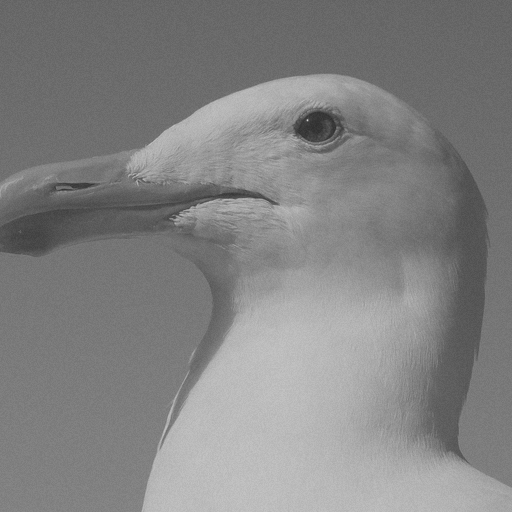

In [ ]:

#@title Obtain and cut out the image { display-mode: "form", run: "auto"}
icon_size = 512
seed = 42
bg_noise_opacity = 0.2 #@param {type:"number"}
icon_opacity = 0.8 #@param {type:"number"}
is_gray = True #@param {type:"boolean"}
choosed_img = 'bird' #@param ["twitter_logo", "dog", "bird", "lena", "custom_url"] {type:"string"}

custom_url = '' #@param {type:"string"}

#@markdown There are some image examples for the creatavity initialize. Also you can try your own images by replace the url variable.

urls = {}
urls['bird'] = r'https://upload.wikimedia.org/wikipedia/commons/9/9a/Gull_portrait_ca_usa.jpg'
urls['lena'] = r'https://p0.itc.cn/q_70/images03/20210511/ac77f8122cc240979568a365faae4dc3.jpeg'
urls['dog'] = r'https://img.freepik.com/free-photo/french-bulldog-young-dog-posing_155003-34898.jpg?t=st=1649881371~exp=1649881971~hmac=7216f9bbd3e18036eba085d730a88738b59c3faf6ddd98f62c268a06e63e85b0&w=2000'
urls['twitter_logo'] = r'https://about.twitter.com/content/dam/about-twitter/en/brand-toolkit/brand-download-img-1.jpg.twimg.1920.jpg'
urls['custom_url'] = custom_url
url = urls[choosed_img]
img = Image.open(urlopen(url))

icon_img = img.convert("RGBA")


w, h = icon_img.size

if w > h:
    left, upper, right, lower = ((w - h) // 2, 0, w - (w - h) // 2, h)
    icon_img = icon_img.crop((left, upper, right, lower))
else:
    left, upper, right, lower = (0, (h - w) // 2, w, h - (h - w) // 2)

icon_img = icon_img.resize((icon_size, icon_size), Image.ANTIALIAS)

sketch_array = np.asarray(icon_img.convert("L")).T

if icon_opacity < 1:
    icon_img = Image.blend(
            Image.new("RGBA", (icon_size, icon_size), (0, 0, 0, 0)),
            icon_img,
            icon_opacity,
        )
icon_bg = Image.new("RGBA", (icon_size, icon_size), 'white')
if seed:
    np.random.seed(seed)

noise = np.uint8(np.random.rand(icon_size, icon_size) * 255)
noise_array = np.stack(
    [
        noise,
        noise,
        noise,
        np.uint8(np.full((icon_size, icon_size), 255 * bg_noise_opacity)),
    ],
    axis=2,
)
noise_img = Image.fromarray(
    noise_array,
    mode="RGBA",
)


icon_bg = Image.alpha_composite(icon_bg, noise_img)
icon_bg.paste(icon_img, (0, 0), icon_img)
if is_gray:
    icon_bg = ImageOps.grayscale(icon_bg)
icon_bg.save("content_with_noise.png")
display(icon_bg)

In [ ]:
#@title Training parameters setting { display-mode: "form", run: "auto"}
prompt_image_path = "content_with_noise.png"
seed = 42
init_image = ""
target_images = ""
#@markdown Input the prompt texts, multiple tests can be connected with " | " and set weight by ":number"
#@markdown Example: `A white bird flies in the blue sky:2 | Vincent Van Gogh style`
texts = 'Vincent Van Gogh style' #@param {type:"string"}
width = 512
height = 512
use_init_image = True #@param {type:"boolean"}
if use_init_image:
  assert os.path.exists(prompt_image_path), f"Image {prompt_image_path} not found"
  init_image = prompt_image_path

use_target_image = True #@param {type:"boolean"}
if use_target_image:
  assert os.path.exists(prompt_image_path), f"Image {prompt_image_path} not found"
  target_images = prompt_image_path
enable_postprocessing = True #@param {type:"boolean"}

#@markdown ---
learning_rate = 0.1 #@param {type:"slider", min:0.00, max:0.30, step:0.01}
max_steps = 200 #@param {type:"integer"}
images_interval = 50 #@param {type:"integer"}

Using device: cuda:0
Using texts: ['Vincent Van Gogh style']
Using image prompts: ['content_with_noise.png']
Using seed: 42
taming.models.vqgan.VQModel
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


  0%|          | 0/200 [00:00<?, ?it/s]

i: 0, loss: 1.16934, losses: 0.941987, 0.227358


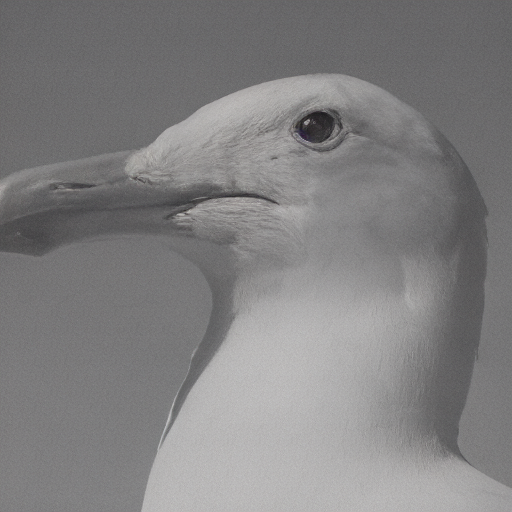

 25%|██▌       | 50/200 [00:38<01:52,  1.33it/s]

i: 50, loss: 0.964723, losses: 0.856097, 0.108626


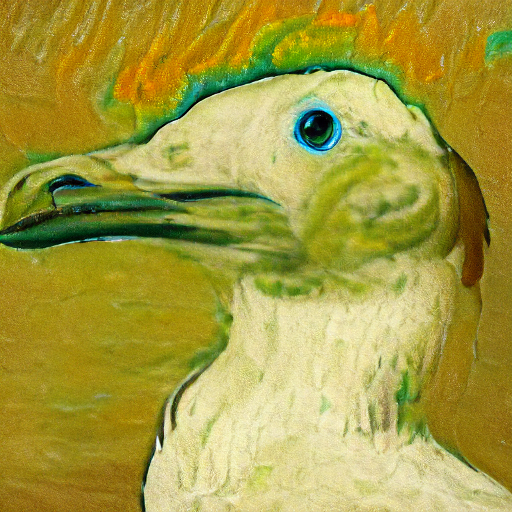

 50%|█████     | 100/200 [01:16<01:14,  1.34it/s]

i: 100, loss: 1.02831, losses: 0.817525, 0.210787


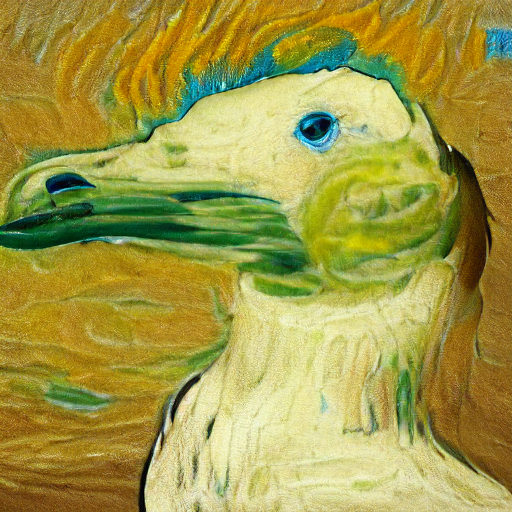

 75%|███████▌  | 150/200 [01:54<00:37,  1.33it/s]

i: 150, loss: 0.924258, losses: 0.783506, 0.140752


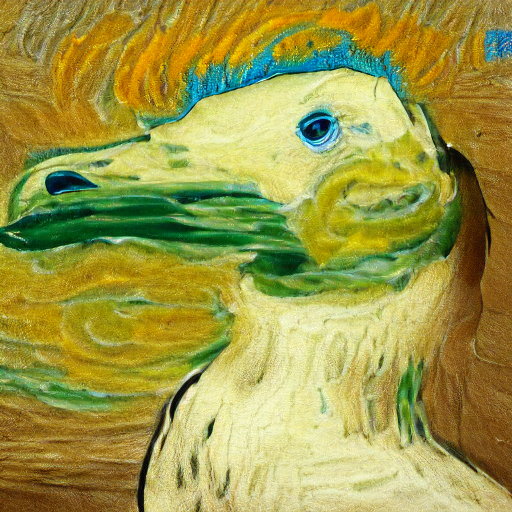

100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


i: 200, loss: 0.903064, losses: 0.799806, 0.103258


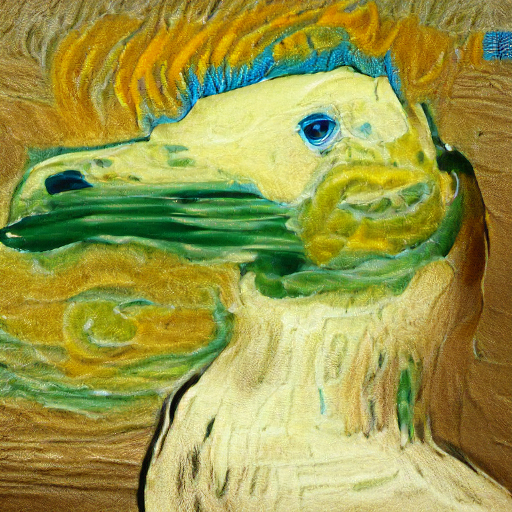

In [ ]:
#@title Start generation {display-mode: "form"}

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


!rm -rf steps
!mkdir steps
model_name = 'vqgan_imagenet_f16_16384'

if seed == -1:
    seed = None
if init_image == "None":
    init_image = None
if target_images == "None" or not target_images:
    model_target_images = []
else:
    model_target_images = target_images.split("|")
    model_target_images = [image.strip() for image in model_target_images]

model_texts = [phrase.strip() for phrase in texts.split("|")]
if model_texts == ['']:
    model_texts = []


args = argparse.Namespace(
    prompts=model_texts,
    image_prompts=model_target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model_name}.yaml',
    vqgan_checkpoint=f'{model_name}.ckpt',
    step_size=learning_rate,
    cutn=32,
    cut_pow=1.,
    display_freq=images_interval,
    seed=seed,
)
from urllib.request import urlopen

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if model_texts:
    print('Using texts:', model_texts)
if model_target_images:
    print('Using image prompts:', model_target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

cut_size = perceptor.visual.input_resolution

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f

if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
    e_dim = 256
    n_toks = model.quantize.n_embed
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

if args.init_image:
    if 'http' in args.init_image:
        img = Image.open(urlopen(args.init_image))
    else:
        img = Image.open(args.init_image)
    pil_image = img.convert('RGB')
    if pil_image.size != (width, height):
      print(f"Resizing source image to {width}x{height}")
      pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    pil_tensor = TF.to_tensor(pil_image)
    z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
else:
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z = one_hot @ model.quantize.embed.weight
    else:
        z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    z = torch.rand_like(z)*2
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)
scheduler = StepLR(opt, step_size=5, gamma=0.95)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                std=[0.26862954, 0.26130258, 0.27577711])



pMs = []
losses = []

# text prompts encoded by clip
for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

# target image prompts encoded by clip
for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = Image.open(path)
    pil_image = img.convert('RGB')
    img = resize_image(pil_image, (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop, gray=enable_postprocessing).to(device))

for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

def synth(z):
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    display(disImg('progress.png'))

def ascend_txt():
    out = synth(z)
    out_gray = TF.rgb_to_grayscale(out, num_output_channels=3)
    feature = perceptor.encode_image(normalize(make_cutouts(out))).float()
    feature_gray = perceptor.encode_image(normalize(make_cutouts(out_gray))).float()
    result = []

    if args.init_weight:
        result.append(F.mse_loss(z, torch.zeros_like(z_orig)) * ((1/torch.tensor(i*2 + 1))*args.init_weight) / 2)
    for prompt in pMs:
        result.append(prompt(feature, feature_gray))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    img = Image.fromarray(img)

    img.save(f"./steps/{i:03d}.png")
    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    losses.append([i.item() for i in lossAll])
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    scheduler.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

losses = []
try:
    for i in tqdm(range(max_steps)):
        train(i)
    checkin(max_steps, ascend_txt())
except KeyboardInterrupt:
    pass
